In [5]:
from collections import defaultdict
import numpy as np
import random
import asyncio
import itertools
import matplotlib.pyplot as plt
from math import sqrt
from scipy.spatial.distance import pdist, squareform, euclidean
from scipy.special import gamma
from itertools import combinations, product
from sklearn.cluster import DBSCAN, OPTICS
import csv
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

In [2]:
epsilon = 0.1

N = 5
WINDOW_MIN = 8
WINDOW = 15

WISHART_K = 4
WISHART_H = 0.2

STEPS, EPS = 30, 0.05

Q_VALUE = 0.99

In [3]:
class Lorentz:
    def __init__(self, s = 10, r = 28, b = 8/3):
        self.s = s
        self.r = r
        self.b = b

    def X(self, x, y, s):
        return s * (y - x)

    def Y(self, x, y, z, r):
        return (-x) * z + r * x - y

    def Z(self, x, y, z, b):
        return x * y - b * z

    def RK4(self, x, y, z, s, r, b, dt):
        k_1 = self.X(x, y, s)
        l_1 = self.Y(x, y, z, r)
        m_1 = self.Z(x, y, z, b)

        k_2 = self.X((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), s)
        l_2 = self.Y((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), (z + m_1 * dt * 0.5), r)
        m_2 = self.Z((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), (z + m_1 * dt * 0.5), b)

        k_3 = self.X((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), s)
        l_3 = self.Y((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), (z + m_2 * dt * 0.5), r)
        m_3 = self.Z((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), (z + m_2 * dt * 0.5), b)

        k_4 = self.X((x + k_3 * dt), (y + l_3 * dt), s)
        l_4 = self.Y((x + k_3 * dt), (y + l_3 * dt), (z + m_3 * dt), r)
        m_4 = self.Z((x + k_3 * dt), (y + l_3 * dt), (z + m_3 * dt), b)

        x += (k_1 + 2 * k_2 + 2 * k_3 + k_4) * dt * (1/6)
        y += (l_1 + 2 * l_2 + 2 * l_3 + l_4) * dt * (1/6)
        z += (m_1 + 2 * m_2 + 2 * m_3 + m_4) * dt * (1/6)

        return (x, y, z)

    def generate(self, dt, steps):
        x_0, y_0, z_0 = 1, 1, 1

        x_list = [x_0]
        y_list = [y_0]
        z_list = [z_0]

        i = 0

        while i < steps:
            x = x_list[i]
            y = y_list[i]
            z = z_list[i]

            position = self.RK4(x, y, z, self.s, self.r, self.b, dt)

            x_list.append(position[0])
            y_list.append(position[1])
            z_list.append(position[2])

            i += 1

        x_array = np.array(x_list)
        y_array = np.array(y_list)
        z_array = np.array(z_list)

        return x_array, y_array, z_array

In [4]:
xs, _, _ = Lorentz().generate(0.1, 10399)
xs = (xs - xs.min()) / (xs.max() - xs.min())

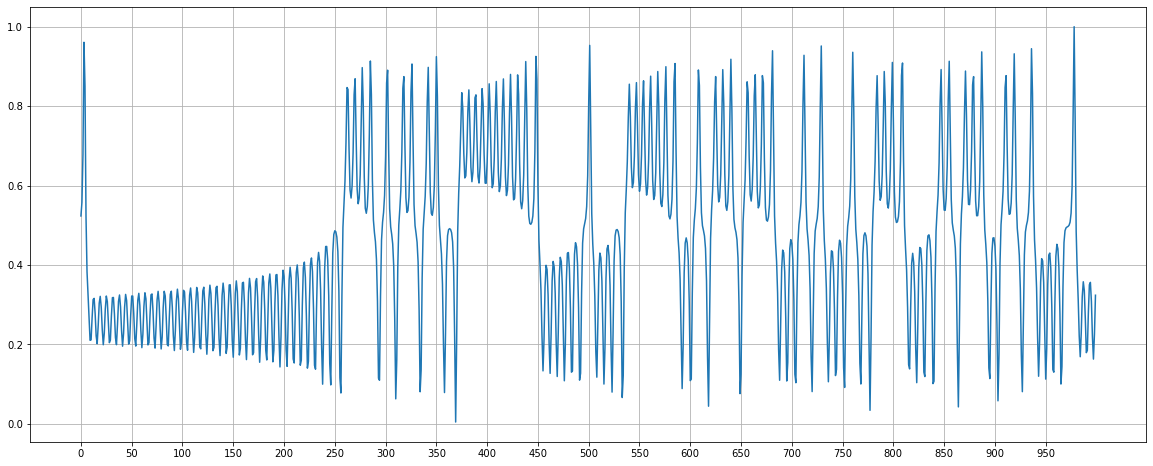

In [5]:
plt.figure(figsize=(20, 8))
plt.plot(xs[:1000])
plt.xticks([i for i in range(0, 1000, 50)])
plt.grid()
plt.show()

In [6]:
list_for_delete = []
for i in range(300):
    list_for_delete.append(i)

xs = np.delete(xs, list_for_delete)

xs_train, xs_test = np.split(xs, [10000])
print(len(xs_train), len(xs_test))

10000 100


In [7]:
xs_train_1 = xs_train[:200]

In [19]:
def create_pat(xs, size_of_pattern, lenght_of_pattern):
    list_of_index = list(range(len(xs)))

    list_of_tuples_with_index = []
    list_with_values = []
    l = list(combinations(range(lenght_of_pattern - 1), size_of_pattern - 1))
    
    for j in range(len(list_of_index) - lenght_of_pattern - 1):
        a = []
        
        for i in range(len(l)):
            b = [False] * lenght_of_pattern
            b[0] = xs[j]
            for k in l[i]:
                b[k + 1] = xs[j + k + 1]
            a.append(b)
        list_with_values += a
        
    return list_with_values

In [20]:
pat = create_pat(xs_train, 5, 8)

In [21]:
len(pat)

349685

In [22]:
pat

[[0.673539473494694,
  0.858321097642523,
  0.8905173916006485,
  0.691431334105239,
  0.5419666772650776,
  False,
  False,
  False],
 [0.673539473494694,
  0.858321097642523,
  0.8905173916006485,
  0.691431334105239,
  False,
  0.4960532274229771,
  False,
  False],
 [0.673539473494694,
  0.858321097642523,
  0.8905173916006485,
  0.691431334105239,
  False,
  False,
  0.47737933417393014,
  False],
 [0.673539473494694,
  0.858321097642523,
  0.8905173916006485,
  0.691431334105239,
  False,
  False,
  False,
  0.4531417013406404],
 [0.673539473494694,
  0.858321097642523,
  0.8905173916006485,
  False,
  0.5419666772650776,
  0.4960532274229771,
  False,
  False],
 [0.673539473494694,
  0.858321097642523,
  0.8905173916006485,
  False,
  0.5419666772650776,
  False,
  0.47737933417393014,
  False],
 [0.673539473494694,
  0.858321097642523,
  0.8905173916006485,
  False,
  0.5419666772650776,
  False,
  False,
  0.4531417013406404],
 [0.673539473494694,
  0.858321097642523,
  0.8905

In [6]:
with open('patterns.csv', newline='') as f:
    reader = csv.reader(f)
    patterns0 = list(reader)
patterns = []

for x in patterns0:
    y = []
    for obj in x:
        if obj != 'False':
            obj = float(obj)
        else:
            obj = False
        y.append(obj)
    patterns.append(y)

In [7]:
with open('out.csv', newline='') as f:
    reader = csv.reader(f)
    patterns0 = list(reader)
patterns1 = []

for x in patterns0:
    y = []
    for obj in x:
        if obj != 'False':
            obj = float(obj)
        else:
            obj = False
        y.append(obj)
    patterns1.append(y)

In [11]:
for i in range(len(patterns0)):
    if patterns[0][0] in patterns0[i]:
        print(patterns0[i])

In [9]:
patterns

[[0.5938395278621514,
  0.5697324911863829,
  0.5968918328727743,
  0.6781322984721427,
  False,
  False,
  False,
  0.59517653878105],
 [0.49419526410653253,
  0.5155290807509704,
  0.5415118930276822,
  0.6000561270785923,
  False,
  False,
  False,
  0.593021149935304],
 [0.5220060083364207,
  0.5489292032817994,
  0.6123875299324213,
  0.7568818189802516,
  False,
  False,
  False,
  0.5003941899931168],
 [0.8709281744095264,
  0.7183861727534903,
  0.5862982391989222,
  0.5494855193901919,
  False,
  False,
  False,
  0.8933785024410416],
 [0.8486925512211494,
  0.7037928658563812,
  0.5938395278621514,
  0.5697324911863829,
  False,
  False,
  False,
  0.8718022821484808],
 [0.8386474005255481,
  0.8486925512211494,
  0.7037928658563812,
  0.5938395278621514,
  False,
  False,
  False,
  0.8215819136017646],
 [0.5048561728213634,
  0.5263458346580381,
  0.5633679967905266,
  0.650732364819203,
  False,
  False,
  False,
  0.545793924587189],
 [0.5700163634477892,
  0.597146614556

In [10]:
patterns0

[['0.673539473494694',
  '0.858321097642523',
  '0.8905173916006485',
  '0.691431334105239',
  '0.5419666772650776',
  'False',
  'False',
  'False'],
 ['0.673539473494694',
  '0.858321097642523',
  '0.8905173916006485',
  '0.691431334105239',
  'False',
  '0.4960532274229771',
  'False',
  'False'],
 ['0.673539473494694',
  '0.858321097642523',
  '0.8905173916006485',
  '0.691431334105239',
  'False',
  'False',
  '0.47737933417393014',
  'False'],
 ['0.673539473494694',
  '0.858321097642523',
  '0.8905173916006485',
  '0.691431334105239',
  'False',
  'False',
  'False',
  '0.4531417013406404'],
 ['0.673539473494694',
  '0.858321097642523',
  '0.8905173916006485',
  'False',
  '0.5419666772650776',
  '0.4960532274229771',
  'False',
  'False'],
 ['0.673539473494694',
  '0.858321097642523',
  '0.8905173916006485',
  'False',
  '0.5419666772650776',
  'False',
  '0.47737933417393014',
  'False'],
 ['0.673539473494694',
  '0.858321097642523',
  '0.8905173916006485',
  'False',
  '0.5419